In [1]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time

In [2]:
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_UInt16)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def tif_save_bands(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[2],img.shape[1],img.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    for i in range(img.shape[0]):
        new_img.GetRasterBand(i+1).WriteArray(img[i,:,:])
    new_img.FlushCache()
    del new_img

# 图像预处理

In [3]:
shp_root='/home/hk/python_script/Ukraine/data/UNOSAT/Syria/'
img_root='/data4/Syria_img/'
k=['A','B','C','D','E']
name=[os.path.basename(i).split('_')[0] for i in glob(shp_root+'*settlements.shp')]#城市名
points_pathes={}#损毁点路径dict
img_pathes={}#图像路径dict
no_shp_pathes={}#未分析区域shp文件
settlements_pathes={}
cloud_shp_pathes=glob(shp_root+'*cloud.shp')

for n in name:
    n_p={}
    for k_ in k:
        p=glob(shp_root+f'{n}_{k_}_2*.shp')
        if len(p)!=0:
            n_p[k_]=p[0]
    points_pathes[n]=n_p
for n in name:
    n_p={}
    for k_ in k:
        p=glob(img_root+f'{n}_{k_}*.tif')
        if len(p)!=0:
            n_p[k_]=p[0]
    img_pathes[n]=n_p
for n in name:
    no_shp_pathes[n]=shp_root+n+'_NoAnalysis.shp'
for n in name:
    settlements_pathes[n]=shp_root+n+'_settlements.shp'


Raqqa


Warning 1: Failed to fetch spatial reference on layer Raqqa_settlements to build transformer, assuming matching coordinate systems.


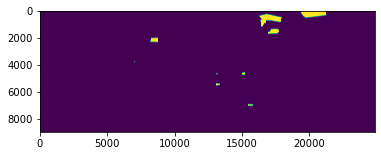

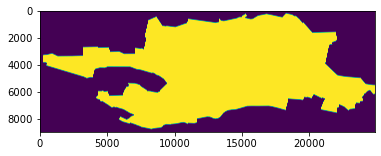

/data2/Syria_img/Raqqa_A_20100703.tif
255
/data2/Syria_img/Raqqa_C_20140212.tif
255
/data2/Syria_img/Raqqa_D_20150529.tif
255


In [32]:

#切割边界，去除军事区
for n in name:
    print(n)

    ds=gdal.Open(img_pathes[n]['A'])
    w,h=ds.RasterXSize,ds.RasterYSize
    noanalysis_mask=get_mask(no_shp_pathes[n],ds.GetGeoTransform(),[h,w])
    settlements_mask=get_mask(settlements_pathes[n],ds.GetGeoTransform(),[h,w])
    plt.imshow(noanalysis_mask)
    plt.show()
    plt.imshow(settlements_mask)
    plt.show()
    img_pathes_city=img_pathes[n]

    for k_ in img_pathes_city.keys():
        try:
            print(img_pathes_city[k_])
            img=read_img(img_pathes_city[k_])
            trf=img['trf']
            img=img['img'].transpose(1,2,0)
            img=img.astype(np.int)
            print(img.max())
            for i in range(3):
                img[:,:,i][settlements_mask==0]=999
                img[:,:,i][noanalysis_mask==1]=999
            # print('show')
            # plt.imshow(img)
            # plt.show()
            save_path=img_pathes_city[k_].replace('.tif','_treated.tif')
            img=img.transpose(2,0,1)
            tif_save_bands(img,save_path,trf,p='4326')
            del img
            gc.collect()
        except:
            print('ERROR',img_pathes_city[k_])
    

In [4]:
#更新img_pathes
for n in name:
    n_p={}
    for k_ in k:
        p=glob(img_root+f'{n}_{k_}*_treated.tif')
        if len(p)!=0:
            n_p[k_]=p[0]
    img_pathes[n]=n_p

In [8]:
img_pathes

{'Homs': {'A': '/data4/Syria_img/Homs_A_20100629_treated.tif',
  'B': '/data4/Syria_img/Homs_B_20130926_treated.tif',
  'C': '/data4/Syria_img/Homs_C_20140421_treated.tif'},
 'Idlib': {'A': '/data4/Syria_img/Idlib_A_20100322_treated.tif',
  'B': '/data4/Syria_img/Idlib_B_20130915_treated.tif',
  'C': '/data4/Syria_img/Idlib_C_20140502_treated.tif',
  'D': '/data4/Syria_img/Idlib_D_20150406_treated.tif',
  'E': '/data4/Syria_img/Idlib_E_20160801_treated.tif'},
 'Raqqa': {'A': '/data4/Syria_img/Raqqa_A_20100703_treated.tif',
  'C': '/data4/Syria_img/Raqqa_C_20140212_treated.tif',
  'D': '/data4/Syria_img/Raqqa_D_20150529_treated.tif'},
 'Aleppo': {'A': '/data4/Syria_img/Aleppo_A_20100704_treated.tif',
  'B': '/data4/Syria_img/Aleppo_B_20130923_treated.tif',
  'C': '/data4/Syria_img/Aleppo_C_20140523_treated.tif',
  'D': '/data4/Syria_img/Aleppo_D_20150426_treated.tif',
  'E': '/data4/Syria_img/Aleppo_E_20150918_treated.tif'},
 'Deir-ez-Zor': {'A': '/data4/Syria_img/Deir-ez-Zor_A_20090327

/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Aleppo_C_cloud.shp
/data2/Syria_img/Aleppo_C_20140523_treated.tif


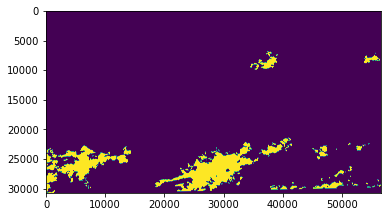

999
show
save
/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Idlib_C_cloud.shp
/data2/Syria_img/Idlib_C_20140502_treated.tif


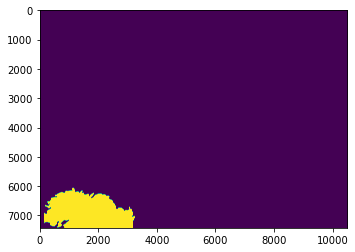

999
show


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


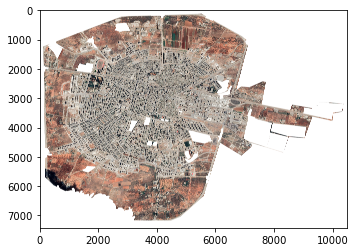

save


In [6]:
#去云

for cloud_path in cloud_shp_pathes:
    n=os.path.basename(cloud_path).split('_')[0]
    k_=os.path.basename(cloud_path).split('_')[1]
    img_path=img_pathes[n][k_]
    print(cloud_path)
    print(img_path)
    ds=gdal.Open(img_path)
    w,h=ds.RasterXSize,ds.RasterYSize
    cloud_mask=get_mask(cloud_path,ds.GetGeoTransform(),[h,w])
    plt.imshow(cloud_mask)
    plt.show()
    img=read_img(img_path)
    trf=img['trf']
    img=img['img'].transpose(1,2,0)
    img=img.astype(np.int)
    print(img.max())
    for i in range(3):
        img[:,:,i][cloud_mask==1]=999
    print('show')
    if 'Aleppo' not in img_path:
        plt.imshow(img)
        plt.show()
    img=img.transpose(2,0,1)
    print('save')
    tif_save_bands(img,img_path,trf,p='4326')


In [39]:
for n in name:
    print(n)
    img_pathes_city=img_pathes[n]
    for k_ in img_pathes_city.keys():

        ds=gdal.Open(img_pathes_city[k_])
        print(ds.GetGeoTransform())

Homs
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
Idlib
(36.613311767578125, 5.364418029785156e-06, 0.0, 35.947265625, 0.0, -5.364418029785156e-06)
(36.613311767578125, 5.364418029785156e-06, 0.0, 35.947265625, 0.0, -5.364418029785156e-06)
(36.613311767578125, 5.364418029785156e-06, 0.0, 35.947265625, 0.0, -5.364418029785156e-06)
(36.613311767578125, 5.364418029785156e-06, 0.0, 35.947265625, 0.0, -5.364418029785156e-06)
(36.613311767578125, 5.364418029785156e-06, 0.0, 35.947265625, 0.0, -5.364418029785156e-06)
Raqqa
(38.928680419921875, 5.364418029785156e-06, 0.0, 35.976104736328125, 0.0, -5.364418029785156e-06)
(38.928680419921875, 5.364418029785156e-06, 0.0, 35.976104736328125, 0.0, -5.364418029785156e-06)
(38.928680419921875, 5.364418029785156e

# 转换图像为Patch

In [12]:
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,0),(0,size-shape[1]%size),(0,size-shape[2]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([shape[0],int(shape[1]/size),-1,shape[2]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],shape[2],int(shape[3]/size),-1])
    return {'img':img.transpose((0,1,3,2,4)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}
size=120
for n in name:
    img_pathes_city=img_pathes[n]

    for k_ in img_pathes_city.keys():
        try:    
            path=img_pathes_city[k_]
            print(path)
            data=read_img(path)
            print(data['img'].shape)
            data2=get_patch(data,size)
            print(data2['img'].shape)
            print(data2['trf'])
            d=data2['img'].astype(np.int16)
            info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度','trf':data2['trf'],'shape':[data['img'].shape,d.shape]}

            np.save(path.replace('.tif',f'_size_{size}.npy'),d)
            print('max:',d.max())
            torch.save(info,path.replace('.tif',f'_size_{size}_info.pth'))
            del data,data2,d
            gc.collect()
        except:
                print('ERROR',img_pathes_city[k_])

/data2/Syria_img/Homs_A_20100629_treated.tif
(3, 15616, 18176)
(3, 131, 152, 120, 120)
(36.66549414396286, 0.0006437301635742188, 0.0, 34.766238033771515, 0.0, -0.0006437301635742188)
max: 999
/data2/Syria_img/Homs_B_20130926_treated.tif
(3, 15616, 18176)
(3, 131, 152, 120, 120)
(36.66549414396286, 0.0006437301635742188, 0.0, 34.766238033771515, 0.0, -0.0006437301635742188)
max: 999
/data2/Syria_img/Homs_C_20140421_treated.tif
(3, 15616, 18176)
(3, 131, 152, 120, 120)
(36.66549414396286, 0.0006437301635742188, 0.0, 34.766238033771515, 0.0, -0.0006437301635742188)
max: 999
/data2/Syria_img/Idlib_A_20100322_treated.tif
(3, 7424, 10496)
(3, 62, 88, 120, 120)
(36.61330908536911, 0.0006437301635742188, 0.0, 35.947268307209015, 0.0, -0.0006437301635742188)
max: 999
/data2/Syria_img/Idlib_B_20130915_treated.tif
(3, 7424, 10496)
(3, 62, 88, 120, 120)
(36.61330908536911, 0.0006437301635742188, 0.0, 35.947268307209015, 0.0, -0.0006437301635742188)
max: 999
/data2/Syria_img/Idlib_C_20140502_treat

# 制作patch的label

In [8]:
patch_pathes={}
for n in name:
    n_p={}
    for k_ in k:
        p=glob(img_root+f'{n}_{k_}*.npy')
        if len(p)!=0:
            n_p[k_]=p[0]
    patch_pathes[n]=n_p
patch_pathes

{'Homs': {'A': '/data4/Syria_img/Homs_A_20100629_treated_size_120.npy',
  'B': '/data4/Syria_img/Homs_B_20130926_treated_size_120.npy',
  'C': '/data4/Syria_img/Homs_C_20140421_treated_size_120.npy'},
 'Idlib': {'A': '/data4/Syria_img/Idlib_A_20100322_treated_size_120.npy',
  'B': '/data4/Syria_img/Idlib_B_20130915_treated_size_120.npy',
  'C': '/data4/Syria_img/Idlib_C_20140502_treated_size_120.npy',
  'D': '/data4/Syria_img/Idlib_D_20150406_treated_size_120.npy',
  'E': '/data4/Syria_img/Idlib_E_20160801_treated_size_120.npy'},
 'Raqqa': {'A': '/data4/Syria_img/Raqqa_A_20100703_treated_size_120.npy',
  'C': '/data4/Syria_img/Raqqa_C_20140212_treated_size_120.npy',
  'D': '/data4/Syria_img/Raqqa_D_20150529_treated_size_120.npy'},
 'Aleppo': {'A': '/data4/Syria_img/Aleppo_A_20100704_treated_size_120.npy',
  'B': '/data4/Syria_img/Aleppo_B_20130923_treated_size_120.npy',
  'C': '/data4/Syria_img/Aleppo_C_20140523_treated_size_120.npy',
  'D': '/data4/Syria_img/Aleppo_D_20150426_treated_

In [5]:
def get_dam_mask(point,patch_file,weight):
    ds=gdal.Open(patch_file)
    trf=ds.GetGeoTransform()
    shape=[ds.RasterYSize,ds.RasterXSize]
    # trf=torch.load(patch_file[1])['trf']
    # shape=torch.load(patch_file[1])['shape'][1]
    p_coor=[shapely.geometry.mapping(list(point)[i])['coordinates'] for i in range(len(point))]
    mask=np.zeros((shape[0],shape[1]))
    p_x_y=[[int((i[0]-trf[0])/trf[1]),int((i[1]-trf[3])/trf[5])] for i in p_coor]
    for i in p_x_y:
        try:
            mask[i[1],i[0]]+=weight
        except:
            pass
    return mask
def get_mask(points_path,patch_path):
    df=gpd.read_file(points_path)
    print(len(df))
    point_num={}
    point=df[df['DmgCls']=='Destroyed']['geometry']
    point_num['destroyed']=len(point)
    print('destroyed:',len(point))
    mask_destroyed=get_dam_mask(point,patch_path,1)
    # point=df[df['DmgCls']=='Severe Damage']['geometry']
    # point_num['severe']=len(point)
    # print('Severe Damage:',len(point))
    # mask_severe=get_dam_mask(point,patch_path,1)
    # point=df[df['DmgCls']=='Moderate Damage']['geometry']
    # point_num['moderate']=len(point)
    # print('Moderate Damage:',len(point))
    # mask_moderate=get_dam_mask(point,patch_path,1)

    # mask=mask_destroyed*6+mask_severe*3+mask_moderate
    # date=df['SensDt'][0]
    # print(f'{n}  {date}得分',dict(Counter(list(mask.flatten()))))
    # mask_type=np.zeros(mask.shape)
    # mask_type[mask>0]=1
    # mask_type[mask>=6]=2
    # print(f'{date}损毁类型',Counter(list(mask_type.flatten())))
    # all_mask=[mask_destroyed,mask_severe,mask_moderate,mask,mask_type]
    # info='5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
    # result={'info':info,'point_num':point_num,'mask':all_mask}
    return mask_destroyed
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,size-shape[0]%size),(0,size-shape[1]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([int(shape[0]/size),-1,shape[1]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],int(shape[2]/size),-1])
    return {'img':img.transpose((0,2,1,3)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}

In [6]:
img_pathes

{'Homs': {'A': '/data4/Syria_img/Homs_A_20100629_treated.tif',
  'B': '/data4/Syria_img/Homs_B_20130926_treated.tif',
  'C': '/data4/Syria_img/Homs_C_20140421_treated.tif'},
 'Idlib': {'A': '/data4/Syria_img/Idlib_A_20100322_treated.tif',
  'B': '/data4/Syria_img/Idlib_B_20130915_treated.tif',
  'C': '/data4/Syria_img/Idlib_C_20140502_treated.tif',
  'D': '/data4/Syria_img/Idlib_D_20150406_treated.tif',
  'E': '/data4/Syria_img/Idlib_E_20160801_treated.tif'},
 'Raqqa': {'A': '/data4/Syria_img/Raqqa_A_20100703_treated.tif',
  'C': '/data4/Syria_img/Raqqa_C_20140212_treated.tif',
  'D': '/data4/Syria_img/Raqqa_D_20150529_treated.tif'},
 'Aleppo': {'A': '/data4/Syria_img/Aleppo_A_20100704_treated.tif',
  'B': '/data4/Syria_img/Aleppo_B_20130923_treated.tif',
  'C': '/data4/Syria_img/Aleppo_C_20140523_treated.tif',
  'D': '/data4/Syria_img/Aleppo_D_20150426_treated.tif',
  'E': '/data4/Syria_img/Aleppo_E_20150918_treated.tif'},
 'Deir-ez-Zor': {'A': '/data4/Syria_img/Deir-ez-Zor_A_20090327

In [22]:
img_pathes

{'Homs': {'A': '/data4/Syria_img/Homs_A_20100629_treated.tif',
  'B': '/data4/Syria_img/Homs_B_20130926_treated.tif',
  'C': '/data4/Syria_img/Homs_C_20140421_treated.tif'},
 'Idlib': {'A': '/data4/Syria_img/Idlib_A_20100322_treated.tif',
  'B': '/data4/Syria_img/Idlib_B_20130915_treated.tif',
  'C': '/data4/Syria_img/Idlib_C_20140502_treated.tif',
  'D': '/data4/Syria_img/Idlib_D_20150406_treated.tif',
  'E': '/data4/Syria_img/Idlib_E_20160801_treated.tif'},
 'Raqqa': {'A': '/data4/Syria_img/Raqqa_A_20100703_treated.tif',
  'C': '/data4/Syria_img/Raqqa_C_20140212_treated.tif',
  'D': '/data4/Syria_img/Raqqa_D_20150529_treated.tif'},
 'Aleppo': {'A': '/data4/Syria_img/Aleppo_A_20100704_treated.tif',
  'B': '/data4/Syria_img/Aleppo_B_20130923_treated.tif',
  'C': '/data4/Syria_img/Aleppo_C_20140523_treated.tif',
  'D': '/data4/Syria_img/Aleppo_D_20150426_treated.tif',
  'E': '/data4/Syria_img/Aleppo_E_20150918_treated.tif'},
 'Deir-ez-Zor': {'A': '/data4/Syria_img/Deir-ez-Zor_A_20090327

In [21]:
for n in name:
    print(n)
    img_pathes_n=img_pathes[n]
    kk=list(img_pathes_n)
    kk.remove('A')
    print(kk)
    for k_ in kk:
        # raise
        points_path=points_pathes[n][k_]
        print(points_path)
        try:
            img_path=img_pathes[n][k_]

            result=get_mask(points_path,img_path)
            d=get_patch({'img':result,'trf':gdal.Open(img_path).GetGeoTransform()},120)
            print(d['trf'])
            patch=torch.load(patch_pathes[n][k_].replace('.npy','_info.pth'))
            print(patch['trf'])
            print(d['img'].shape)
            print(patch['shape'][1])
            np.save(img_path.replace('.tif','_img_dammask.npy'),d['img'])
            print('__________________________SAVE SUCCESS__________________________')
            print(' ')
            print(' ')

        except:
            print('ERROR',points_path)

Homs
['B', 'C']
Idlib
['B', 'C', 'D', 'E']
Raqqa
['C', 'D']
Aleppo
['B', 'C', 'D', 'E']
Deir-ez-Zor
['B', 'C', 'D', 'E']
Hama
['B', 'C']


In [29]:
# raise
n='Hama'
k_='D'
points_path=points_pathes[n][k_]
print(points_path)
# try:
img_path=img_pathes[n]['C']

result=get_mask(points_path,img_path)
d=get_patch({'img':result,'trf':gdal.Open(img_path).GetGeoTransform()},120)
print(d['trf'])
patch=torch.load(patch_pathes[n]['C'].replace('.npy','_info.pth'))
print(patch['trf'])
print(d['img'].shape)
print(patch['shape'][1])
np.save('/data4/Syria_img/Hama_D_20160706_treated_img_dammask.npy',d['img'])
print('__________________________SAVE SUCCESS__________________________')
print(' ')
print(' ')

# except:
#     print('ERROR',points_path)

/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Hama_D_2016-07-06.shp
10885
destroyed: 9459
(36.716305911540985, 0.0006437301635742188, 0.0, 35.183718502521515, 0.0, -0.0006437301635742188)
(36.716305911540985, 0.0006437301635742188, 0.0, 35.183718502521515, 0.0, -0.0006437301635742188)
(163, 135, 120, 120)
(3, 163, 135, 120, 120)
__________________________SAVE SUCCESS__________________________
 
 


In [7]:
dammask_pathes={}
for n in name:
    n_p={}
    for k_ in k:
        p=glob(img_root+f'{n}_{k_}*_dammask.pth.tar')
        if len(p)!=0:
            n_p[k_]=p[0]
    dammask_pathes[n]=n_p
dammask_pathes

{'Homs': {'B': '/data2/Syria_img/Homs_B_20130926_treated_size_120_dammask.pth.tar',
  'C': '/data2/Syria_img/Homs_C_20140421_treated_size_120_dammask.pth.tar'},
 'Idlib': {'B': '/data2/Syria_img/Idlib_B_20130915_treated_size_120_dammask.pth.tar',
  'C': '/data2/Syria_img/Idlib_C_20140502_treated_size_120_dammask.pth.tar',
  'D': '/data2/Syria_img/Idlib_D_20150406_treated_size_120_dammask.pth.tar',
  'E': '/data2/Syria_img/Idlib_E_20160801_treated_size_120_dammask.pth.tar'},
 'Raqqa': {'B': '/data2/Syria_img/Raqqa_B_20131022_treated_size_120_dammask.pth.tar',
  'C': '/data2/Syria_img/Raqqa_C_20140212_treated_size_120_dammask.pth.tar',
  'D': '/data2/Syria_img/Raqqa_D_20150529_treated_size_120_dammask.pth.tar'},
 'Aleppo': {'B': '/data2/Syria_img/Aleppo_B_20130923_treated_size_120_dammask.pth.tar',
  'C': '/data2/Syria_img/Aleppo_C_20140523_treated_size_120_dammask.pth.tar',
  'D': '/data2/Syria_img/Aleppo_D_20150426_treated_size_120_dammask.pth.tar',
  'E': '/data2/Syria_img/Aleppo_E_20

# 制作样本

In [8]:
def get_samples(pre_patch,post_patch,dammask):
        if (pre_patch.shape!=post_patch.shape 
        or dammask['mask'][0].shape[0]!=pre_patch.shape[1] 
        or dammask['mask'][0].shape[1]!=pre_patch.shape[2]):
                raise('SHAPE ERROR')
        else:
                shape=pre_patch.shape
                print(shape)
        zz=np.zeros((shape[1],shape[2]))
        samples=[]
        for x in range(shape[1]):
                for y in range(shape[2]):

                        if (pre_patch[:,x,y]==999).any() and (post_patch[:,x,y]==999).any():
                                continue
                        else:
                                samples.append([[x,y],[int(i[x,y]) for i in dammask['mask']],pre_patch[:,x,y],post_patch[:,x,y]])
                                zz[x,y]=1
        return samples,zz


samples_root=img_root+'Syria_samples/'
for n in name:
    print(n)
    print('loading pre')
    pre_patch=np.load(patch_pathes[n]['A'])
    patch_pathes_n=patch_pathes[n]
    kk=list(patch_pathes_n)
    kk.remove('A')
    for k_ in kk:
        print(f'loading pre-{k_} and dammask-{k_}')
        post_patch=np.load(patch_pathes[n][k_])
        dammask=torch.load(dammask_pathes[n][k_])
        samples,_=get_samples(pre_patch,post_patch,dammask)
        print('writing samples',len(samples))
        time.sleep(2)
        samples_pre_pathes=[samples_root+'samples/pre/'+f'{n}_{k_}_{i}.png' for i in range(len(samples))]
        samples_post_pathes=[samples_root+'samples/post/'+f'{n}_{k_}_{i}.png' for i in range(len(samples))]
        info=[]
        for i in tqdm(range(len(samples))):
                # '5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
                info.append([samples_pre_pathes[i],samples_post_pathes[i],samples[i][0],samples[i][1]])
                imageio.imwrite(samples_pre_pathes[i],samples[i][2].transpose(1,2,0).astype(np.uint8))
                imageio.imwrite(samples_post_pathes[i],samples[i][3].transpose(1,2,0).astype(np.uint8))
        info_dict={'readme':'4个字段\n 1:pre图像路径\n 2:post图像路径\n 3:图像坐标\n 4:损毁信息\n 损毁信息有5层\n 5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6', 'info':info}
        torch.save(info_dict,samples_root+f'{n}_{k_}_samples_info.pth')


Homs
loading pre
loading pre-B and dammask-B
(3, 131, 152, 120, 120)
writing samples 9652


100%|██████████| 9652/9652 [01:35<00:00, 100.78it/s]


loading pre-C and dammask-C


# 创建samples_slip文件

In [26]:
#按照有无完全损毁划分
samples_list_files=glob('/data2/Syria_img/Syria_samples/*.pth')
all_samples_list=[]
print('load sample list files')
time.sleep(2)
for i in tqdm(samples_list_files):
    all_samples_list+=torch.load(i)['info']
p_sample_list=[i[0] for i in all_samples_list if i[3][0]>0]
n_sample_list=[i[0] for i in all_samples_list if i[3][0]==0]
print('N:',len(n_sample_list))
print('P:',len(p_sample_list))
random.shuffle(n_sample_list)
random.shuffle(p_sample_list)
n_n=int(len(n_sample_list)*2/3)
p_n=int(len(p_sample_list)*2/3)
n_train_sample_list=[n_sample_list[i] for i in range(len(n_sample_list)) if i<n_n]
n_val_sample_list=[n_sample_list[i] for i in range(len(n_sample_list)) if i>=n_n]
p_train_sample_list=[p_sample_list[i] for i in range(len(p_sample_list)) if i<p_n]
p_val_sample_list=[p_sample_list[i] for i in range(len(p_sample_list)) if i>=p_n]
print(len(n_train_sample_list),len(n_val_sample_list))
print(len(p_train_sample_list),len(p_val_sample_list))
split_save_dir='/data2/Syria_img/Syria_samples/split_havedamaged/'
torch.save(n_train_sample_list,split_save_dir+'train_n.pth')
torch.save(n_val_sample_list,split_save_dir+'val_n.pth')
torch.save(p_train_sample_list,split_save_dir+'train_p.pth')
torch.save(p_val_sample_list,split_save_dir+'val_p.pth')

load sample list files


100%|██████████| 18/18 [00:01<00:00, 11.22it/s]


N: 254291
P: 9479
169527 84764
6319 3160


In [24]:
#按照有无完全损毁划分
samples_list_files=glob('/data2/Syria_img/Syria_samples/*.pth')
all_samples_list=[]
print('load sample list files')
time.sleep(2)
for i in tqdm(samples_list_files):
    all_samples_list+=torch.load(i)['info']
n_sample_list=[i[0] for i in all_samples_list if i[3][4]<2]
p_sample_list=[i[0] for i in all_samples_list if i[3][4]==2]
print('N:',len(n_sample_list))
print('P:',len(p_sample_list))
random.shuffle(n_sample_list)
random.shuffle(p_sample_list)
n_n=int(len(n_sample_list)*2/3)
p_n=int(len(p_sample_list)*2/3)
n_train_sample_list=[n_sample_list[i] for i in range(len(n_sample_list)) if i<n_n]
n_val_sample_list=[n_sample_list[i] for i in range(len(n_sample_list)) if i>=n_n]
p_train_sample_list=[p_sample_list[i] for i in range(len(p_sample_list)) if i<p_n]
p_val_sample_list=[p_sample_list[i] for i in range(len(p_sample_list)) if i>=p_n]
print(len(n_train_sample_list),len(n_val_sample_list))
print(len(p_train_sample_list),len(p_val_sample_list))
split_save_dir='/data2/Syria_img/Syria_samples/split_type2/'
torch.save(n_train_sample_list,split_save_dir+'train_n.pth')
torch.save(n_val_sample_list,split_save_dir+'val_n.pth')
torch.save(p_train_sample_list,split_save_dir+'train_p.pth')
torch.save(p_val_sample_list,split_save_dir+'val_p.pth')

load sample list files


100%|██████████| 18/18 [00:01<00:00, 13.08it/s]


N: 248156
P: 15614
165437 82719
10409 5205


In [23]:
#正样本数量
files=glob('/data2/Syria_img/*dammask.pth.tar')
files.sort()
for f in files:
    print(f)
    masks=torch.load(f)
    print(masks['mask'][0].sum())

/data2/Syria_img/Aleppo_B_20130923_treated_size_120_dammask.pth.tar
202.0
/data2/Syria_img/Aleppo_C_20140523_treated_size_120_dammask.pth.tar
1450.0
/data2/Syria_img/Aleppo_D_20150426_treated_size_120_dammask.pth.tar
2538.0
/data2/Syria_img/Aleppo_E_20150918_treated_size_120_dammask.pth.tar
4773.0
/data2/Syria_img/Deir-ez-Zor_B_20131024_treated_size_120_dammask.pth.tar
285.0
/data2/Syria_img/Deir-ez-Zor_C_20140513_treated_size_120_dammask.pth.tar
452.0
/data2/Syria_img/Deir-ez-Zor_D_20150510_treated_size_120_dammask.pth.tar
538.0
/data2/Syria_img/Deir-ez-Zor_E_20160525_treated_size_120_dammask.pth.tar
802.0
/data2/Syria_img/Hama_B_20130926_treated_size_120_dammask.pth.tar
4585.0
/data2/Syria_img/Hama_C_20140305_treated_size_120_dammask.pth.tar
4670.0
/data2/Syria_img/Hama_D_20140305_treated_size_120_dammask.pth.tar
9459.0
/data2/Syria_img/Homs_B_20130926_treated_size_120_dammask.pth.tar
2524.0
/data2/Syria_img/Homs_C_20140421_treated_size_120_dammask.pth.tar
2950.0
/data2/Syria_img/Idl